<a href="https://colab.research.google.com/github/MarianaPires93/OP/blob/main/Dl_morelayers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Neural Network:**

*   Importing libraries





In [51]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import tensorflow_datasets as tfds

*   Auxiliary Code




In [52]:
def plot_acuracy_loss(history):
    """
    Adapted from: https://www.tensorflow.org/tutorials/images/classification
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

*   Load **dataset** and information


In [53]:
tfds.load("malaria")

{'train': <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [54]:
ds_info = tfds.load("malaria")
print(ds_info)

{'train': <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}


In [55]:
builder = tfds.builder('malaria')
info = builder.info

info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

*   Data Preperation



In [56]:
# Load the malaria dataset
ds_train_full, ds_info = tfds.load('malaria', split='train', as_supervised=True, with_info=True)

# Define sample sizes
train_size = 7000
test_size = 1500
val_size = 1500

# Split the full dataset into train, test, and val splits
ds_train = ds_train_full.take(train_size)
ds_train_full = ds_train_full.skip(train_size)

ds_test = ds_train_full.take(test_size)
ds_train_full = ds_train_full.skip(test_size)

ds_val = ds_train_full.take(val_size)

# Print the lengths of the subsets
print("Length of training set:", len(list(ds_train)))
print("Length of test set:", len(list(ds_test)))
print("Length of validation set:", len(list(ds_val)))


Length of training set: 7000
Length of test set: 1500
Length of validation set: 1500


*   Show examples



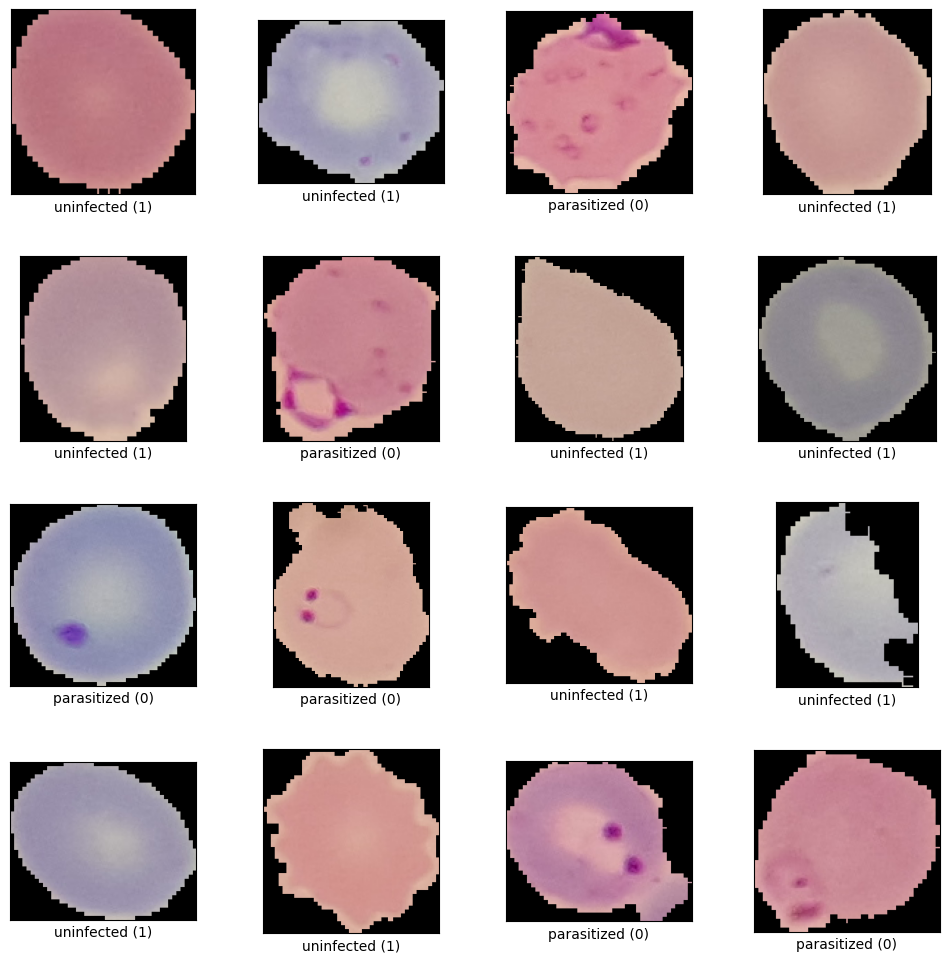

In [57]:
fig = tfds.show_examples(ds_train, ds_info, rows=4, cols=4)

*   Normalize Data



In [58]:
def normalize_image(image, label):
    return tf.cast(image, tf.float32) /255.0, label

In [59]:
normalize_ds_train = ds_train.map(normalize_image)
normalize_ds_test = ds_test.map(normalize_image)
normalize_ds_val = ds_val.map(normalize_image)

*  Resize Images





In [60]:
def resize_image(image, label, target_height=200, target_width=200):
    return tf.image.resize_with_pad(image, target_height, target_width), label

In [61]:
resized_ds_train = normalize_ds_train.map(resize_image)
resized_ds_test = normalize_ds_test.map(resize_image)
resized_ds_val = normalize_ds_val.map(resize_image)

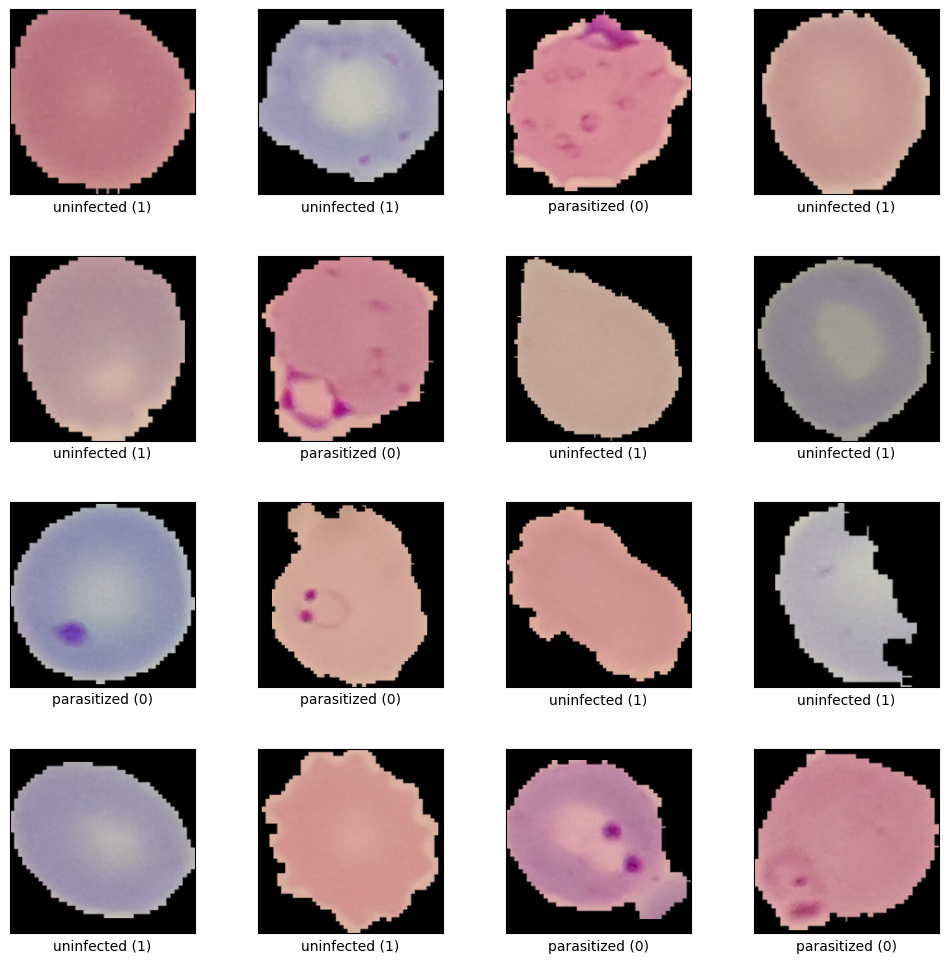

In [62]:
fig2 = tfds.show_examples(resized_ds_train, ds_info, rows=4, cols=4) #Show resized

In [63]:
resized_ds_train = resized_ds_train.batch(256)
resized_ds_test = resized_ds_test.batch(256)
resized_ds_val = resized_ds_val.batch(256)

# **Model**

In [64]:
kernel_regularizer = tf.keras.regularizers.L2(0.01) #Prevent overfitting in machine learning models

In [69]:
l2_model = Sequential([
    layers.Input(shape=(200, 200, 3)),  # Specify input shape
    layers.Conv2D(16, (6,6), activation='relu'),
    layers.MaxPooling2D(),  #Max Pooling Layer: Max-pooling layer to reduce spatial dimensions while retaining important information

    layers.Conv2D(16, (6,6), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(), #Flattens the output from the previous layer into a 1D array, preparing it to be input into a dense layer
    layers.Dense(128, activation='relu'), #dense layers can only receive 1D information
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [70]:
l2_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [71]:
l2_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 195, 195, 16)      1744      
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 97, 97, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 92, 92, 16)        9232      
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 46, 46, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 44, 44, 32)        4640      
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 22, 22, 32)      

*  Training Model



In [73]:
epochs=2
history = l2_model.fit(
  resized_ds_train,
  validation_data=resized_ds_val,
  epochs=epochs
)

Epoch 1/2
28/28 [==============================] - 447s 16s/step - loss: 0.6683 - accuracy: 0.5847 - val_loss: 0.6296 - val_accuracy: 0.6580
Epoch 2/2
28/28 [==============================] - 448s 16s/step - loss: 0.5033 - accuracy: 0.7583 - val_loss: 0.3401 - val_accuracy: 0.8500


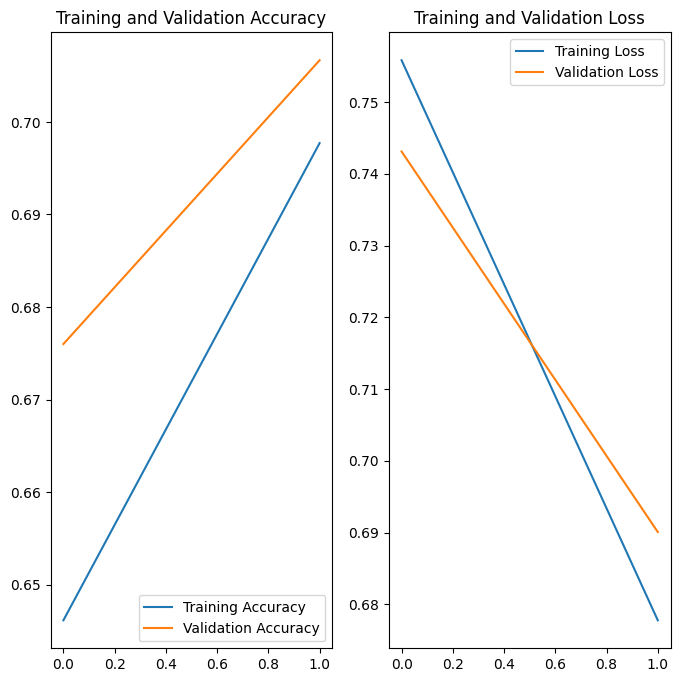

In [ ]:
plot_acuracy_loss(history)

*   Testing Model





In [ ]:
epochs=2
history = l2_model.fit(
  resized_ds_test,
  validation_data=resized_ds_val,
  epochs=epochs
)